In [ ]:
!pip install sentencepiece

     |████████████████████████████████| 1.2 MB 8.4 MB/s 


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import sentencepiece as spm

In [ ]:
corpus = tf.keras.utils.get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')
prefix = "shakespeare_subword_embedding"
vocab_size = 10000
spm.SentencePieceTrainer.train(
    f"--input={corpus} --model_prefix={prefix} --vocab_size={vocab_size}" + 
    " --model_type=bpe" +
    " --max_sentence_length=999999" + # 문장 최대 길이
    " --pad_id=0 --pad_piece=[PAD]" + # pad (0)
    " --unk_id=1 --unk_piece=[UNK]" + # unknown (1)
    " --bos_id=2 --bos_piece=[BOS]" + # begin of sequence (2)
    " --eos_id=3 --eos_piece=[EOS]" + # end of sequence (3)
    " --user_defined_symbols=[SEP],[CLS],[MASK]"
)

1122304/1115394 [==============================] - 0s 0us/step


In [ ]:
vocab_file = "./shakespeare_subword_embedding.model"
vocab = spm.SentencePieceProcessor()
vocab.load(vocab_file)

True

In [ ]:
len(vocab)

10000

In [ ]:
path_to_file = tf.keras.utils.get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')
f = open(path_to_file, 'r')
lines = f.readlines()
encoded = []
for line in lines:
    pieces = vocab.encode_as_pieces(line)
    ids = vocab.encode_as_ids(line)
    encoded.append(ids)
    # print(f'line: {line}')
    # print(f'pieces: {pieces}')
    # print(f'ids: {ids}')
f.close()

In [ ]:
from tensorflow.keras.preprocessing.sequence import skipgrams

skip_grams = [skipgrams(sample, vocabulary_size=vocab_size, window_size=10) for sample in encoded]

In [ ]:
len(skip_grams)

40000

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, Reshape, Activation, Input
from tensorflow.keras.layers import Dot
from tensorflow.keras.utils import plot_model
from IPython.display import SVG

In [ ]:
embed_size = 100

In [ ]:
# 중심 단어 임베딩 테이블
w_inputs = Input(shape=(1, ), dtype='int32')
word_embedding = Embedding(vocab_size, embed_size)(w_inputs)

# 주변 단어 임베딩 테이블
c_inputs = Input(shape=(1, ), dtype='int32')
context_embedding = Embedding(vocab_size, embed_size)(c_inputs)

In [ ]:
dot_product = Dot(axes=2)([word_embedding, context_embedding])
dot_product = Reshape((1, ), input_shape=(1, 1))(dot_product)
output = Activation('sigmoid')(dot_product)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 100)       1000000     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 100)       1000000     input_2[0][0]                    
______________________________________________________________________________________________

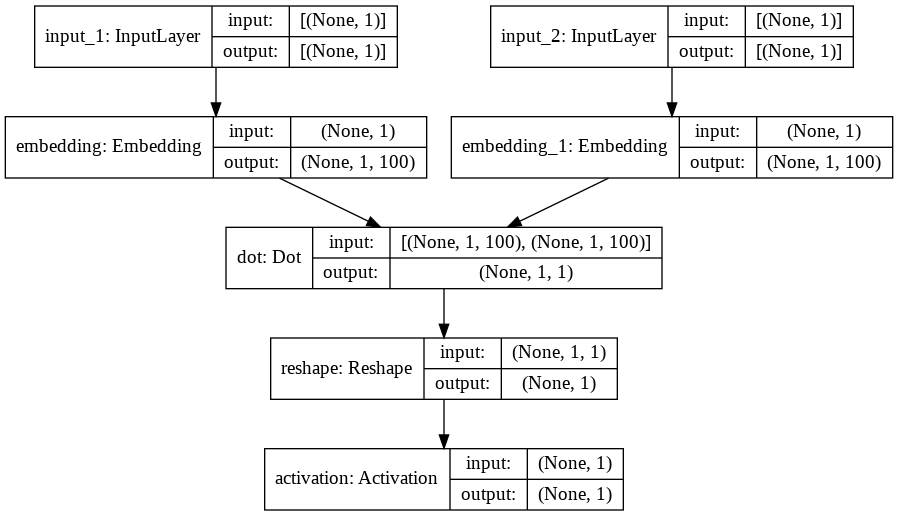

In [ ]:
model = Model(inputs=[w_inputs, c_inputs], outputs=output)
model.summary()
model.compile(loss='binary_crossentropy', optimizer='adam')
plot_model(model, to_file='shakespeare_subword_1.png', show_shapes=True, show_layer_names=True, rankdir='TB')

In [ ]:
for epoch in range(1, 6):
    loss = 0
    for _, elem in enumerate(skip_grams):
        if elem[0] and elem[1]:
            first_elem = np.array(list(zip(*elem[0]))[0], dtype='int32')
            second_elem = np.array(list(zip(*elem[0]))[1], dtype='int32')
            labels = np.array(elem[1], dtype='int32')
            X = [first_elem, second_elem]
            Y = labels
            loss += model.train_on_batch(X,Y)
    print(f'Epoch: {epoch}, Loss: {loss}')

Epoch: 1, Loss: 11696.026264500222
Epoch: 2, Loss: 10184.770907747974
Epoch: 3, Loss: 9560.48333021994
Epoch: 4, Loss: 8968.520530471757
Epoch: 5, Loss: 8465.748957768617
